Let's say, one day you are asked to analyze our developed bike sharing platform.

In [1]:
import numpy as np
from io import BytesIO
import zipfile
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
zip_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'
zip_file = zipfile.ZipFile(BytesIO(urllib.request.urlopen(zip_url).read()))
day_file = zip_file.open('day.csv')

let's peek the data

In [3]:
df = pd.read_csv(day_file)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


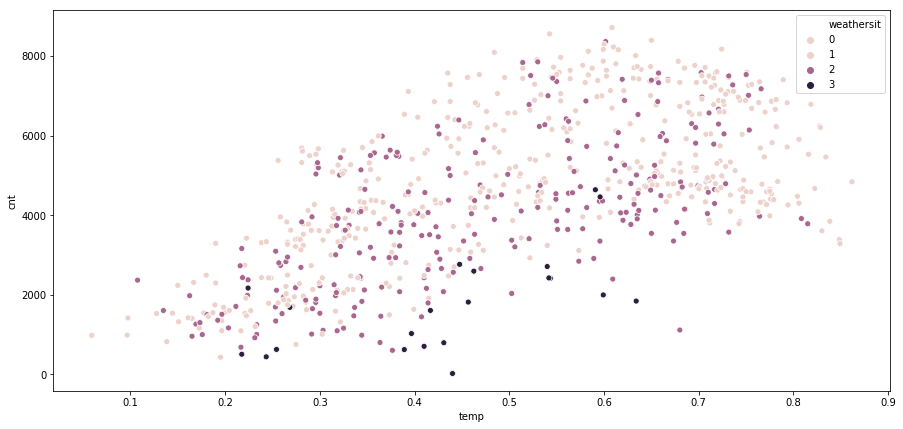

In [4]:
f,ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(
    x='temp',
    y='cnt',
    hue='weathersit',
    data=df,
    ax=ax
)
plt.show()

To simplify our data mining routine, lets assume that we willl only use 2 variables: `temp` and `weathersit` as independent variable and 1 variable `cnt` as our target variable.

We could se that as `temp` variable rises, `cnt` / total rental bikes has also risen. At some certain `temp` it seems to begin downwards.

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics.scorer import make_scorer


def rmse(y_true, y_target):
    return np.sqrt(mean_squared_error(y_true, y_target))

rmse_scorer = make_scorer(rmse)

x_cols = [
    'temp',
    'weathersit'
]
y_col = 'cnt'
model1 = LinearRegression()
model2 = make_pipeline(
    PolynomialFeatures(2),
    LinearRegression()
)

model_1_scores = cross_val_score(model1, df[x_cols], df[y_col], cv=5, scoring=rmse_scorer)
model_2_scores = cross_val_score(model2, df[x_cols], df[y_col], cv=5, scoring=rmse_scorer)

print('model 1 cross validate score: {} (+-){}'.format(model_1_scores.mean(), model_1_scores.std()))
print('model 2 cross validate score: {} (+-){}'.format(model_2_scores.mean(), model_2_scores.std()))

model 1 cross validate score: 1778.479808296309 (+-)540.2884161751009
model 2 cross validate score: 1678.705788441799 (+-)357.7368913879912


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[x_cols], 
    df[y_col],
    test_size=0.3
)
for mdl in [model1, model2]:
    mdl.fit(X_train, y_train)

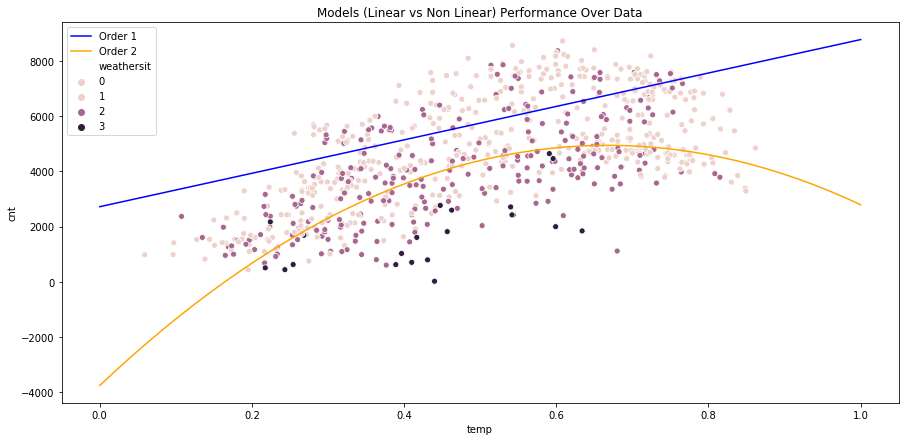

In [20]:
f,ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(
    x='temp',
    y='cnt',
    hue='weathersit',
    data=df,
    ax=ax
)
x1 = np.linspace(0,1)
x2 = np.zeros(x1.shape[0])
x_features = np.stack([x1,x2]).T
plt.plot(x_features.T[0], model1.predict(x_features), color='blue', label='Order 1')
plt.plot(x_features.T[0], model2.predict(x_features), color='orange', label='Order 2')
plt.title('Models (Linear vs Non Linear) Performance Over Data')

plt.legend()
plt.show()

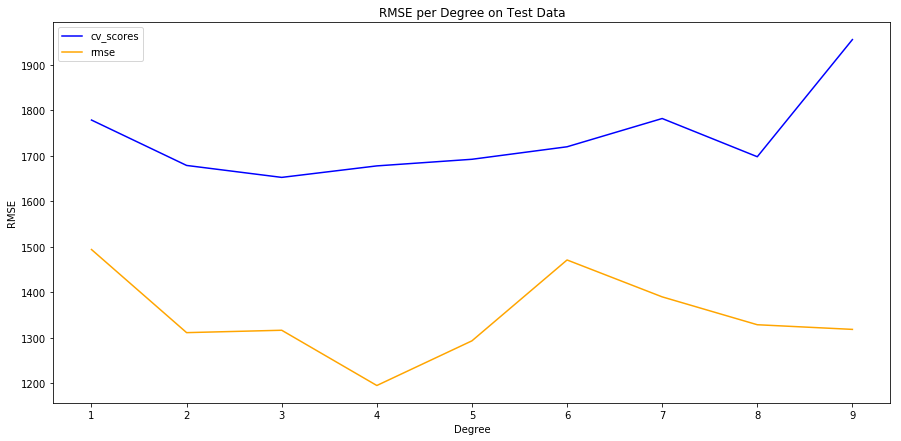

In [14]:
min_degree = 1
max_degree = 10
np.random.seed(19)

scores = dict()
for degree in range(min_degree, max_degree):
    if 'cv_scores' not in scores:
        scores['cv_scores'] = list()
    if 'scores' not in scores:
        scores['scores'] = list()
    
    mdl = make_pipeline(
        PolynomialFeatures(degree),
        LinearRegression()
    )
    cv_score = cross_val_score(mdl, df[x_cols], df[y_col], cv=5, scoring=rmse_scorer).mean()
    
    X_train, X_test, y_train, y_test = train_test_split(df[x_cols], df[y_col], test_size=0.3)
    mdl.fit(X_train, y_train)
    score = rmse(y_test, mdl.predict(X_test))
    
    scores['cv_scores'].append(cv_score)
    scores['scores'].append(score)
    
    
    
    

f, ax = plt.subplots(figsize=(15, 7))
plt.plot(
    [degree for degree in range(min_degree, max_degree)],
    scores['cv_scores'],
    label='cv_scores',
    color='blue'
)
plt.plot(
    [degree for degree in range(min_degree, max_degree)],
    scores['scores'],
    label='rmse',
    color='orange'
)
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.title('RMSE per Degree on Test Data')
plt.legend()
plt.show()

We can see roughly that degree 3 has the least cross validation error. 

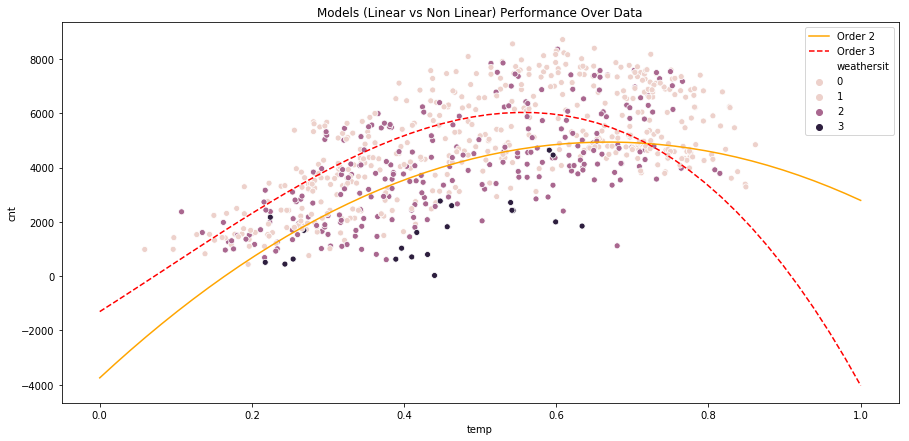

In [21]:
X_train, _, y_train, _ = train_test_split(df[x_cols], df[y_col], test_size=0.3)
mdl = make_pipeline(
    PolynomialFeatures(3),
    LinearRegression()
)
mdl.fit(X_train, y_train)

f,ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(
    x='temp',
    y='cnt',
    hue='weathersit',
    data=df,
    ax=ax
)
x1 = np.linspace(0,1)
x2 = np.zeros(x1.shape[0])
x_features = np.stack([x1,x2]).T
plt.plot(x_features.T[0], model2.predict(x_features), color='orange', label='Order 2')
plt.plot(x_features.T[0], mdl.predict(x_features), color='red', linestyle='--', label='Order 3')
plt.title('Models (Linear vs Non Linear) Performance Over Data')
plt.legend()
plt.show()